In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate a 2D dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, random_state=42)

# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels from {0,1} to {-1,+1}
y_train = 2*y_train - 1
y_test = 2*y_test - 1

In [3]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

In [4]:
def feature_encoding(x):
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')

def variational_circuit(params, x):
    feature_encoding(x)
    for layer_params in params:
        for i, wire_params in enumerate(layer_params):
            qml.RX(wire_params[0], wires=i)
            qml.RY(wire_params[1], wires=i)
            qml.RZ(wire_params[2], wires=i)
        # Entangle qubits
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
    # Measure expectation value on the first qubit’s Z-axis
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface='autograd')
def quantum_model(params, x):
    return variational_circuit(params, x)

In [5]:
def loss(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.stack(predictions)
    return np.mean((predictions - Y)**2)

def accuracy(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.sign(np.stack(predictions))
    return np.mean(predictions == Y)


In [7]:
num_layers = 2
params = 0.01 * np.random.randn(num_layers, n_qubits, 3)

opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 50

epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    params = opt.step(lambda v: loss(v, X_train, y_train), params)
    current_loss = loss(params, X_train, y_train)
    train_acc = accuracy(params, X_train, y_train)
    test_acc = accuracy(params, X_test, y_test)
    
    epoch_list.append(epoch+1)
    loss_list.append(current_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {current_loss:.4f}, "
          f"Train Acc = {train_acc:.2f}, Test Acc = {test_acc:.2f}")

Epoch 1/50: Loss = 1.8891, Train Acc = 0.42, Test Acc = 0.30
Epoch 2/50: Loss = 1.8800, Train Acc = 0.42, Test Acc = 0.30
Epoch 3/50: Loss = 1.8684, Train Acc = 0.42, Test Acc = 0.30
Epoch 4/50: Loss = 1.8533, Train Acc = 0.44, Test Acc = 0.30
Epoch 5/50: Loss = 1.8335, Train Acc = 0.44, Test Acc = 0.30
Epoch 6/50: Loss = 1.8075, Train Acc = 0.45, Test Acc = 0.30
Epoch 7/50: Loss = 1.7737, Train Acc = 0.45, Test Acc = 0.30
Epoch 8/50: Loss = 1.7304, Train Acc = 0.45, Test Acc = 0.30
Epoch 9/50: Loss = 1.6763, Train Acc = 0.44, Test Acc = 0.30
Epoch 10/50: Loss = 1.6108, Train Acc = 0.44, Test Acc = 0.30
Epoch 11/50: Loss = 1.5346, Train Acc = 0.44, Test Acc = 0.35
Epoch 12/50: Loss = 1.4497, Train Acc = 0.44, Test Acc = 0.35
Epoch 13/50: Loss = 1.3596, Train Acc = 0.49, Test Acc = 0.35
Epoch 14/50: Loss = 1.2683, Train Acc = 0.51, Test Acc = 0.45
Epoch 15/50: Loss = 1.1795, Train Acc = 0.53, Test Acc = 0.50
Epoch 16/50: Loss = 1.0962, Train Acc = 0.55, Test Acc = 0.50
Epoch 17/50: Loss

Final Training Accuracy: 0.89
Final Test Accuracy: 1.00


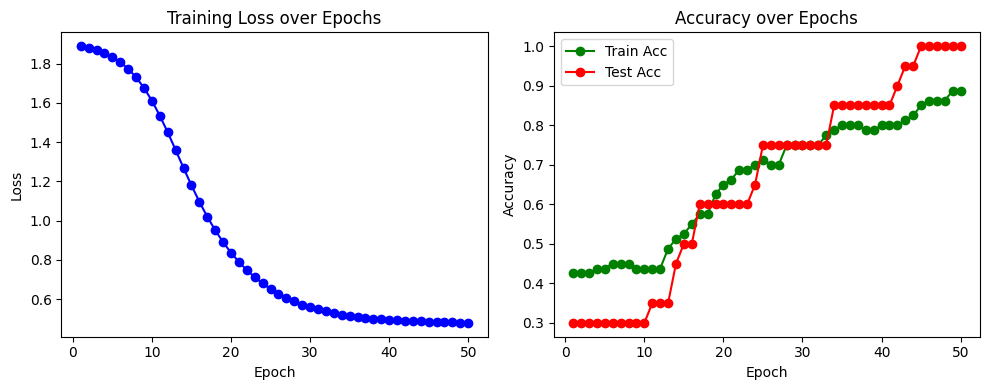

In [8]:
final_train_acc = accuracy(params, X_train, y_train)
final_test_acc = accuracy(params, X_test, y_test)
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}")

plt.figure(figsize=(10,4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epoch_list, loss_list, marker='o', color='blue')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_acc_list, marker='o', label="Train Acc", color='green')
plt.plot(epoch_list, test_acc_list, marker='o', label="Test Acc", color='red')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()